In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    AddChanneld,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    RandAffined,
    Spacingd,
    Invertd,
    Resized,
    RandRotated,
    Rand3DElasticd,
    RandGaussianNoised,
    ToTensord,
    EnsureTyped,
    EnsureType,
    Activations
)

# from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import SimpleITK as sitk
import numpy as np
from tqdm.notebook import tqdm, trange
from livelossplot import PlotLosses
from torchtools.optim import RangerLars # Over9000


In [2]:
root_dir =  'E:/Tanvir Mehedi/Nodule_greater_than_10mm/Saved_Models/'

In [3]:
data_dir = 'E:/Tanvir Mehedi/Nodule_greater_than_10mm/'

train_images = sorted(
    glob.glob(os.path.join(data_dir, "Only_Lung_Portion", "*.nii")))

train_labels = sorted(
    glob.glob(os.path.join(data_dir, "Spherical_Nodule_Mask", "*.nii")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]

train_files, val_files = data_dicts[:20], data_dicts[20:26]

print('Train files : ', len(train_files), '\nValidation files : ', len(val_files))

Train files :  0 
Validation files :  0


In [4]:
set_determinism(seed=0)

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1200, a_max=600,
            b_min=0.0, b_max=1.0, clip=True),
        Orientationd(keys=["image", "label"], axcodes= 'SPL'),
        Spacingd(keys=["image", "label"], pixdim=(
            1., 1., 1.), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(64, 64, 64),
            pos=1,
            neg=0,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandRotated(keys=["image", "label"], range_x=np.pi/12, range_y=np.pi/12, range_z = np.pi/6, prob=0.5, keep_size=True, 
                    mode=["bilinear", "nearest"],),
        
        RandGaussianNoised(keys=['image'], prob=0.25, mean=0, std=0.1),
        
        Rand3DElasticd(keys=["image", "label"], sigma_range = [5,7], magnitude_range = [0,1], 
                       prob = 0.25, mode=["bilinear", "nearest"]),
        
        ToTensord(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1200, a_max=600,
            b_min=0.0, b_max=1.0, clip=True),
        Orientationd(keys=["image", "label"], axcodes="SPL"),
        Spacingd(keys=["image", "label"], pixdim=(
            1., 1., 1.), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
check_ds = Dataset(data=train_files, transform=train_transforms)
#check_ds = Dataset(data=train_files)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"], check_data["label"])
print(f"image shape: {image.shape}, label shape: {label.shape}")


TypeError: 'NoneType' object is not subscriptable

In [16]:
a = 3
plt.figure("check", (12, 6))
for i in range(image.shape[2]):
    print('image', i)
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[a,0,i, :, :], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[a,0,i, :, :],  cmap="gray")
    plt.show()

NameError: name 'image' is not defined

<Figure size 864x432 with 0 Axes>

In [6]:
# Model Parameters
batch_size = 1
num_workers = 0
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [7]:
# Train
train_ds = Dataset(data = train_files, transform = train_transforms)
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = num_workers)

# Validation
val_ds = Dataset(data = val_files, transform = val_transforms)
val_loader = DataLoader(val_ds, batch_size = 1, num_workers = num_workers)

# Test
# test_ds = Dataset(data = test_files, transform = test_transforms)
# test_loader = DataLoader(test_ds, batch_size = batch_size, num_workers = num_workers)


In [8]:
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 1,
#     channels = (32, 64, 128, 256, 512),
    channels=(16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
).to(device).type(torch.float16)


In [9]:
# loss_function = DiceLoss(to_onehot_y = False, sigmoid = True)
loss_function = DiceLoss(to_onehot_y = False, sigmoid = True)

optimizer = torch.optim.Adam(model.parameters(), 1e-3)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01,step_size_up=5,
#                                               mode="triangular2", cycle_momentum = False)
# optimizer = RangerLars(model.parameters(), 1e-2)

dice_metric = DiceMetric(include_background = False, reduction = "mean")


In [10]:
def save_checkpoint(state, filename = 'E:/Tanvir Mehedi/Nodule_greater_than_10mm/Saved_Models/nodule_seg_3d_large_with_aug.pt.tar'):
    
    print('=> Saving Checkpoint')
    torch.save(state, filename)
    

In [11]:
max_epochs = 150

In [12]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([Activations(sigmoid=True)])


In [13]:
liveloss = PlotLosses()


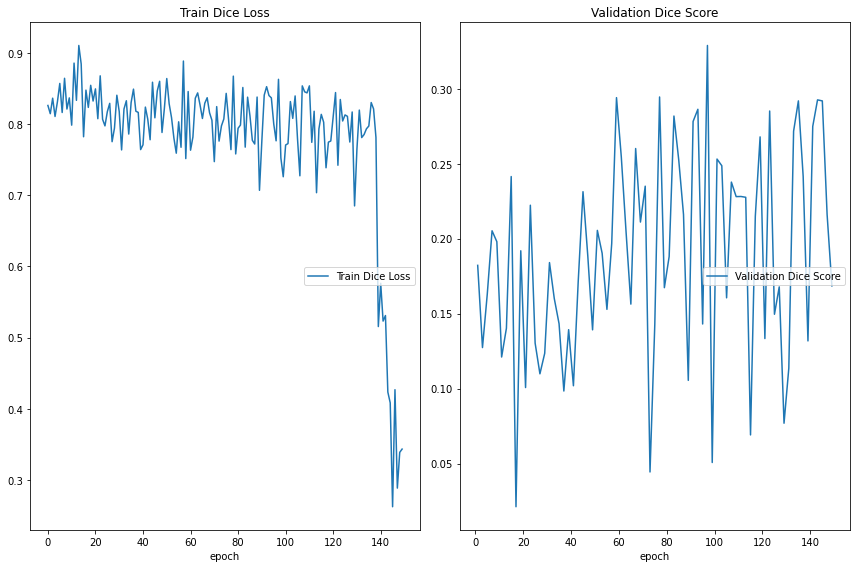

Train Dice Loss
	Train Dice Loss  	 (min:    0.262, max:    0.911, cur:    0.343)
Validation Dice Score
	Validation Dice Score 	 (min:    0.021, max:    0.329, cur:    0.169)


In [15]:
for epoch in range(max_epochs):
    
    logs = {}
    
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device).type(torch.float16),
            batch_data["label"].to(device).type(torch.float16),
        )
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2. , norm_type=2.0)
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    
    if (epoch + 1) % val_interval == 0:
        
        model.eval()
        
        with torch.no_grad():
            
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )

                roi_size = (64, 64, 64)
                sw_batch_size = 1
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
#                 val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred = val_outputs, y = val_labels)
                

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                
                checkpoint = {'model_state' : model.state_dict(), 'optimizer_state' : optimizer.state_dict(), 
                              'Dice_Score' : metric } 
                save_checkpoint(checkpoint)
                
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model_with_aug.pth"))
                
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
            logs['Validation' + ' Dice Score'] = metric
            
    logs['Train' + ' Dice Loss'] = epoch_loss
    
    liveloss.update(logs)
    liveloss.draw()


In [ ]:
metric

In [ ]:
# torch.save(model.state_dict(), os.path.join(
#                     root_dir, "val_score_68.5_for_50_55.pth"))

In [ ]:
np.save('epoch_loss_values.npy', epoch_loss_values)
np.save('metric_values.npy', metric_values)

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Load Saved Model

In [14]:
path = root_dir + 'best_metric_model_with_aug.pth'
model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [ ]:
test_files = data_dicts[50:100]

In [ ]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1200, a_max=600,
            b_min=0.0, b_max=1.0, clip=True),
        Orientationd(keys=["image", "label"], axcodes="SPL"),
        Spacingd(keys=["image", "label"], pixdim=(
            1., 1., 1.), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        
        ToTensord(keys=["image", "label"]),
    ]
)
    
test_ds = Dataset(data = test_files, transform = test_transforms)
test_loader = DataLoader(test_ds, batch_size = batch_size, num_workers = num_workers)

In [ ]:
inputs_all = []
preds_all = []
labels_all = []

model.eval()

with torch.no_grad():

    for val_data in test_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
# -----------
        # compute metric for current iteration  
#                 val_outputs = model(val_inputs)
#                 val_outputs = torch.sigmoid(val_outputs)>0.5
# ----------
        roi_size = (64, 64, 64)
        sw_batch_size = 1
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
#         loss = loss_function(val_outputs, val_labels)
#         print(loss)
        val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
#         val_labels = [post_label(i) for i in decollate_batch(val_labels)]
        
        dice_metric(y_pred = val_outputs, y = val_labels)
        
        inputs_all.append(val_inputs)
        preds_all.append(val_outputs)
        labels_all.append(val_labels)

    # aggregate the final mean dice result
    metric = dice_metric.aggregate().item()
    
    print(metric)


# Visualize output

In [ ]:
type(val_outputs)

In [ ]:
len(inputs_all)

In [ ]:
preds_all[0][0].shape

In [ ]:
val_labels[0][0].shape

In [ ]:
val_outputs[0][0].shape

In [ ]:
len(inputs_all)

In [ ]:
import matplotlib.pyplot as plt

a = 3

inputs = inputs_all[a][0][0].detach().cpu()
preds = preds_all[a][0][0].detach().cpu()
labels = labels_all[a][0][0].detach().cpu()

for i in range(preds.shape[0]):
    
    plt.figure(figsize=(16,16))
    print("image %d" % i)
    
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(inputs[i],  cmap="gray")
    
    plt.subplot(1, 3, 2)
    plt.title("Label")
    plt.imshow(labels[i],  cmap="gray")
    
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(preds[i], cmap="gray")
    plt.show()
    
    

In [ ]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1200, a_max=600,
            b_min=0.0, b_max=1.0, clip=True),
        Orientationd(keys=["image", "label"], axcodes="SPL"),
        Spacingd(keys=["image", "label"], pixdim=(
            1., 1., 1.), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(64, 64, 64),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0),
        ToTensord(keys=["image", "label"]),
    ]
)


In [ ]:
val_ds = Dataset(data = val_files, transform = val_transforms)
val_loader = DataLoader(val_ds, batch_size = 1, num_workers = num_workers)


In [ ]:
model.eval()
        
with torch.no_grad():

    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        val_outputs = model(val_inputs)
        loss = loss_function(val_outputs, val_labels)
        
        val_outputs = torch.sigmoid(val_outputs)>0.5
        dice_metric(y_pred = val_outputs, y = val_labels)
        
        print(loss)
        
    metric = dice_metric.aggregate().item()
    
    print(metric)


In [ ]:
# Check new CT scans

In [ ]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=-1200, a_max=600,
            b_min=0.0, b_max=1.0, clip=True),
        Orientationd(keys=["image", "label"], axcodes="SPL"),
        Spacingd(keys=["image", "label"], pixdim=(
            1., 1., 1.), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        
        ToTensord(keys=["image", "label"]),
    ]
)

test_ds = Dataset(data = test_files, transform = test_transforms)
test_loader = DataLoader(test_ds, batch_size = 1, num_workers = num_workers)

In [ ]:
model.eval()
        
with torch.no_grad():

    for test_data in test_loader:
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        test_outputs = model(test_inputs)
        loss = loss_function(test_outputs, test_labels)
        
        test_outputs = torch.sigmoid(test_outputs)>0.5
        dice_metric(y_pred = test_outputs, y = test_labels)
        
        print(loss)
        
    metric = dice_metric.aggregate().item()
    
    print(metric)
